# Addiction Simulator

## Setup Virtual Environment
1. make sure python3 is installed on your system.
2. make sure you have a python virtual environment setup: 
python -m pip install --upgrade pip setuptools virtualenv
3. create a python environment: 
python -m venv venv (this creates a virtual environment called venv)
4. if applicable add /venv/ to your .gitignore.
5. activate the virtual environment: 
either \venv\Scripts\activate.bat on windows 
or source venv/bin/activate on mac+linux


## Import Libraries

In [1]:
#basic
from os import system, name
import random
import time
import numpy as np
import matplotlib.pyplot as plt

#pytorch for gpu processing of ML model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

#rich library for Terminal UI
from rich.jupyter import print
#from rich import print
from rich.prompt import IntPrompt


#hide pytorch warnings (should eventually be resolved)
import warnings
warnings.filterwarnings("ignore")

## Agent's Brain (Deep Q-Learning)

### Neural Network Model

In [2]:
class Network(nn.Module):  
    def __init__(self, input_size, nb_action):
        #ref: https://discuss.pytorch.org/t/super-model-in-init/97426
        #super(Network, self).__init__()
        super().__init__() #pytorch's NN model
        self.input_size = input_size
        self.nb_action = nb_action
        self.fc1 = nn.Linear(input_size, 30)#arbitrarily chose 30 hidden layers
        self.fc2 = nn.Linear(30, nb_action)
    
    #base pytorch NN model runs and we override the
    #forward function with our own relu activation function
    def forward(self, state):
        x = F.relu(self.fc1(state))
        q_values = self.fc2(x)
        return q_values

### Experience Replay Model
This model is used for training our DQN model. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

In [3]:
class ReplayMemory(): 
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]
    
    def sample(self, batch_size):
        samples = zip(*random.sample(self.memory, batch_size))
        return map(lambda x: Variable(torch.cat(x, 0)), samples)

### DQN Ensemble
Comprised of a neural network model and a memory model. 
* The NN takes in observation of sensor data (brain chemicals) and chooses actions based on the relu activation function. 
* The agent will sample some of the sensor data and store in long term memory to be reused later for training. 
* We also use the Adam Optimisation algorithm. This is an extension to stocastic gradient desent to update weights of the neural network. 

In [4]:
class Dqn():
    def __init__(self, input_size, nb_action, gamma):
        self.gamma = gamma
        self.reward_window = []
        self.model = Network(input_size, nb_action)
        self.memory = ReplayMemory(100000)
        self.optimizer = optim.Adam(self.model.parameters(), lr = 0.001)
        self.last_state = torch.Tensor(input_size).unsqueeze(0)
        self.last_action = 0
        self.last_reward = 0
    
    # select action for x duration
    def select_action(self, state):
        #softmax converts numbers into probabilities
        #Q values are the output of the neural network
        # Temperature value = 100. closer to zero the less sure the NN will be to taking the action
        probs = F.softmax(self.model(Variable(state, volatile = True))*100) # T=100
        #viz q value for each action, (T value by user choice)
        #pie chart 0/1 #seperate action
        action = probs.multinomial(num_samples=1)
        return action.data[0,0]
    
    #to train our AI
    #forward propagation then backproagation
    # get our output, target, compare our output to the target to compute the loss error
    # backproagate loss error into the nn and use stochastic gradient descent we update the weights according to how much they contributed to the loss error
    def learn(self, batch_state, batch_next_state, batch_reward, batch_action):
        outputs = self.model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
        next_outputs = self.model(batch_next_state).detach().max(1)[0]
        target = self.gamma*next_outputs + batch_reward
        td_loss = F.smooth_l1_loss(outputs, target)
        self.optimizer.zero_grad()
        td_loss.backward(retain_graph = True)
        self.optimizer.step()
    
    #When ai reaches a new state we update everything
    #update action, last action becomes the new action but also the last state becomes the new state and last reward becomes the new state
    # we then get this new transition and update our reward window to track training progress and exploration
    def update(self, reward, new_signal):
        new_state = torch.Tensor(new_signal).float().unsqueeze(0)
        self.memory.push((self.last_state, new_state, torch.LongTensor([int(self.last_action)]), torch.Tensor([self.last_reward])))
        action = self.select_action(new_state)
        if len(self.memory.memory) > 100:
            batch_state, batch_next_state, batch_action, batch_reward = self.memory.sample(100)
            self.learn(batch_state, batch_next_state, batch_reward, batch_action)
        self.last_action = action
        self.last_state = new_state
        self.last_reward = reward
        self.reward_window.append(reward)
        if len(self.reward_window) > 1000:
            del self.reward_window[0]
        return action
    
    def score(self):
        return sum(self.reward_window)/(len(self.reward_window)+1.)
    
    def save(self):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, 'last_brain.pth')
    def load(self):
        if os.path.isfile('last_brain.pth'):
            print("=> loading checkpoint... ")
            checkpoint = torch.load('last_brain.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")

## Simulation

In [5]:
class Simulation():    
    def __init__(self):
        # Agent Brain - a neural network that represents our Q-function
        self.agent = Dqn(5,6,0.9) # 5 sensors, 3 actions, gama = 0.9
        #Agent's Actions
        self.agent_actions = ['Binge on Internet', 'Work', 'Exercise', 'Socialise', 'Drink Alcohol', 'Smoke'] #6 actions
        
        #Agent Sensors
        ##ref habits of a happy brain
        ## Happy Chemicals
        self.agent_serotonin = 1 #agent feeling of self achievement
        self.agent_oxytocin = 1 #rewarding agent for being social
        self.agent_dopamine = 1 #agent gets going after a reward
        self.agent_endorphins = 1 #agent gets for pushing through physical pain at different times

        ### Unhappy Chemicals
        self.agent_cortisol = 0 #stress hormone which makes agent feel uncomfortable and wants to do something
        
        # the mean score curve (sliding window of the rewards) with 
        # respect to time.
        self.scores = []

        #the agent's environment
        self.end_day = 365 # day simulation ends
        self.end_hour = 24 # hour simulation ends
        self.current_day = 1 # day agent starts
        self.current_hour = 1 # hour agent starts
        self.previous_time_left = 0

        # temporary. this will change
        self.reward_received = 0 # agent wants to maximise this score

        #habituation will reduce the experience that makes the agent happy because the action is new
        self.habituation = np.zeros((self.end_day,self.end_hour)) # initializing the habituation array with only zeros.

        self.finish = False #trigger to end simulation
        while not self.finish:
            self.finish = self.next_time_interval()

    def next_time_interval(self):
        ## get the time left
        day = self.end_day - self.current_day #difference in current day and end day
        hour = self.end_hour - self.current_hour #difference in current hour and end hour
        time_left = day*24 + hour

        ## agent input state vector, composed of the five brain signals received by being in the environment
        current_state = [self.agent_serotonin, self.agent_oxytocin, self.agent_dopamine, self.agent_endorphins, self.agent_cortisol]
        action_to_take = self.agent.update(self.reward_received, current_state) # playing the action from the ai (dqn class)
        self.scores.append(self.agent.score()) # appending the score (mean of the last 100 rewards to the reward window)

        #This is the limbic system to say what action to take.
        #we can take the agent's NN and call forward to output q values for each state.
        suggested_action = self.agent_actions[action_to_take]
        sa = int(1 if suggested_action=="Binge on Video Games" else 2 if suggested_action=="Work" else 3 if suggested_action=="Exercise" else 4 if suggested_action=="Socialise" else 5 if suggested_action=="Drink Alcohol" else 6 if suggested_action=="Smoke" else 0)
        
        #give user options
        self.clear()
        print("** Current Day: [bold dark_violet]" + str(self.current_day) + "[/bold dark_violet], Current Hour: [bold dark_violet]" + str(self.current_hour) + "[/bold dark_violet], Time Left: [bold dark_violet]" + str(time_left) + "[/bold dark_violet] hrs ** \n")
        print("- [bold dark_green]Serotonin: " + str("#" * self.agent_serotonin) + "[/bold dark_green]")
        print("- [bold dark_green]Oxytocin: " + str("#" * self.agent_oxytocin) + "[/bold dark_green]")
        print("- [bold dark_green]Dopamine: " + str("#"*self.agent_dopamine) + "[/bold dark_green]")
        print("- [bold dark_green]Endorphins: " + str("#"*self.agent_endorphins) + "[/bold dark_green]")
        print("- [bold dark_red]Cortisol: " + str("#"*self.agent_serotonin) + "[/bold dark_red]")
        print("\n1. [bold dark_violet]Binge on Internet[/bold dark_violet]\n2. [bold dark_violet]Work[/bold dark_violet]\n3. [bold dark_violet]Exercise[/bold dark_violet]\n4. [bold dark_violet]Socialise[/bold dark_violet]\n5. [bold dark_violet]Drink Alcohol[/bold dark_violet]\n6. [bold dark_violet]Smoke[/bold dark_violet]\n")
        action_taken = 0
        action_taken = IntPrompt.ask("Choose from 1 to 6", default=sa)

        #update agent brain chemicals after action taken
        if(action_taken == 1): #Binge on Internet
            self.agent_serotonin += 0
            self.agent_oxytocin += 0
            self.agent_dopamine += 1
            self.agent_endorphins += 0
            self.agent_cortisol += 0
        elif(action_taken == 2): # Work
            self.agent_serotonin += 1
            self.agent_oxytocin += 0
            self.agent_dopamine -= 1
            self.agent_endorphins += 0
            self.agent_cortisol += 1
        elif(action_taken == 3): #Exercise
            self.agent_serotonin += 1
            self.agent_oxytocin += 0
            self.agent_dopamine += 1
            self.agent_endorphins += 0
            self.agent_cortisol += 0
        elif(action_taken == 4): #Socialise
            self.agent_serotonin += 0
            self.agent_oxytocin += 1
            self.agent_dopamine += 1
            self.agent_endorphins += 0
            self.agent_cortisol += 0
        elif(action_taken == 5): #Drink Alcohol
            self.agent_serotonin += 0
            self.agent_oxytocin += 0
            self.agent_dopamine += 1
            self.agent_endorphins += 0
            self.agent_cortisol += 0
        elif(action_taken == 6): #Smoke
            self.agent_serotonin += 0
            self.agent_oxytocin += 0
            self.agent_dopamine += 1
            self.agent_endorphins += 0
            self.agent_cortisol += 0
        elif(action_taken == 0):#quit
            #print("saving brain...")
            #brain.save()
            plt.title("Scores")
            plt.xlabel("Epochs")
            plt.ylabel("Reward")
            plt.plot(self.scores)
            plt.show()
            return True   #end simulation

#indp. only dopamine is max reward,
# seperate good actions and bad action
# user action vs inertia of agent
# user action at start import..,
# repeated user actions can eventually change agent's actions
# viz what past actions were taken by user.

#e.g represent person who is alcoholic.
        #reward and punishment conditions
        self.reward_received = self.agent_serotonin + self.agent_oxytocin + self.agent_dopamine + self.agent_endorphins - self.agent_cortisol
        if(self.habituation[0,0] > 0):
            self.reward_received = -1 # reward -1 for repeating an action
        else:
            #otherwise
            self.reward_received = -0.2 # it gets bad reward (-0.2)
            if time_left < self.previous_time_left: # however if it getting close to the goal
                self.reward_received = 0.1 # it still gets slightly positive reward 0.1 just for surviving

        #check if this is the last round otherwise continue
        if(time_left <= 0):
            return True   #end simulation
        else:    
            # Updating the last time from the agent to the end time (goal)
            self.current_day += 1  #update to next day interval
            if(self.current_day > self.end_day):
                self.current_day = self.end_day
            self.current_hour += 1 #update to next hour interval
            if(self.current_hour > self.end_hour):
                self.current_hour = 0
            self.previous_time_left = time_left
            return False

    def clear(self): 
        """
        This function was taken from https://www.geeksforgeeks.org/clear-screen-python/ to
        allow the terminal to be cleared when changing menus or showing the user important
        messages. It checks what operating system is being used and uses the correct 
        clearing command.
        """
        # for windows 
        if name == 'nt': 
            _ = system('cls') 

        # for mac and linux(here, os.name is 'posix')
        else: 
            _ = system('clear')

** Current Day: 1, Current Hour: 1, Time Left: 8759 hrs **

- Serotonin: #

- Oxytocin: #

- Dopamine: #

- Endorphins: #

- Cortisol: #

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 2, Current Hour: 2, Time Left: 8734 hrs **

- Serotonin: #

- Oxytocin: #

- Dopamine: ##

- Endorphins: #

- Cortisol: #

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 3, Current Hour: 3, Time Left: 8709 hrs **

- Serotonin: #

- Oxytocin: #

- Dopamine: ###

- Endorphins: #

- Cortisol: #

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 4, Current Hour: 4, Time Left: 8684 hrs **

- Serotonin: #

- Oxytocin: #

- Dopamine: ####

- Endorphins: #

- Cortisol: #

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 5, Current Hour: 5, Time Left: 8659 hrs **

- Serotonin: #

- Oxytocin: #

- Dopamine: #####

- Endorphins: #

- Cortisol: #

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 6, Current Hour: 6, Time Left: 8634 hrs **

- Serotonin: #

- Oxytocin: #

- Dopamine: ######

- Endorphins: #

- Cortisol: #

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 7, Current Hour: 7, Time Left: 8609 hrs **

- Serotonin: #

- Oxytocin: #

- Dopamine: #######

- Endorphins: #

- Cortisol: #

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 8, Current Hour: 8, Time Left: 8584 hrs **

- Serotonin: #

- Oxytocin: #

- Dopamine: ########

- Endorphins: #

- Cortisol: #

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 9, Current Hour: 9, Time Left: 8559 hrs **

- Serotonin: #

- Oxytocin: #

- Dopamine: #########

- Endorphins: #

- Cortisol: #

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 10, Current Hour: 10, Time Left: 8534 hrs **

- Serotonin: #

- Oxytocin: #

- Dopamine: ##########

- Endorphins: #

- Cortisol: #

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 11, Current Hour: 11, Time Left: 8509 hrs **

- Serotonin: #

- Oxytocin: #

- Dopamine: ###########

- Endorphins: #

- Cortisol: #

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 12, Current Hour: 12, Time Left: 8484 hrs **

- Serotonin: #

- Oxytocin: #

- Dopamine: ############

- Endorphins: #

- Cortisol: #

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 13, Current Hour: 13, Time Left: 8459 hrs **

- Serotonin: ##

- Oxytocin: #

- Dopamine: ###########

- Endorphins: #

- Cortisol: ##

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 14, Current Hour: 14, Time Left: 8434 hrs **

- Serotonin: ###

- Oxytocin: #

- Dopamine: ##########

- Endorphins: #

- Cortisol: ###

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 15, Current Hour: 15, Time Left: 8409 hrs **

- Serotonin: ####

- Oxytocin: #

- Dopamine: #########

- Endorphins: #

- Cortisol: ####

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 16, Current Hour: 16, Time Left: 8384 hrs **

- Serotonin: #####

- Oxytocin: #

- Dopamine: ########

- Endorphins: #

- Cortisol: #####

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 17, Current Hour: 17, Time Left: 8359 hrs **

- Serotonin: ######

- Oxytocin: #

- Dopamine: #######

- Endorphins: #

- Cortisol: ######

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 18, Current Hour: 18, Time Left: 8334 hrs **

- Serotonin: #######

- Oxytocin: #

- Dopamine: ######

- Endorphins: #

- Cortisol: #######

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 19, Current Hour: 19, Time Left: 8309 hrs **

- Serotonin: ########

- Oxytocin: #

- Dopamine: #####

- Endorphins: #

- Cortisol: ########

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 20, Current Hour: 20, Time Left: 8284 hrs **

- Serotonin: #########

- Oxytocin: #

- Dopamine: ####

- Endorphins: #

- Cortisol: #########

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 21, Current Hour: 21, Time Left: 8259 hrs **

- Serotonin: ##########

- Oxytocin: #

- Dopamine: ###

- Endorphins: #

- Cortisol: ##########

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 22, Current Hour: 22, Time Left: 8234 hrs **

- Serotonin: ###########

- Oxytocin: #

- Dopamine: ##

- Endorphins: #

- Cortisol: ###########

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 23, Current Hour: 23, Time Left: 8209 hrs **

- Serotonin: ############

- Oxytocin: #

- Dopamine: #

- Endorphins: #

- Cortisol: ############

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 24, Current Hour: 24, Time Left: 8184 hrs **

- Serotonin: #############

- Oxytocin: #

- Dopamine: 

- Endorphins: #

- Cortisol: #############

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 25, Current Hour: 0, Time Left: 8184 hrs **

- Serotonin: ##############

- Oxytocin: #

- Dopamine: 

- Endorphins: #

- Cortisol: ##############

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 26, Current Hour: 1, Time Left: 8159 hrs **

- Serotonin: ###############

- Oxytocin: #

- Dopamine: 

- Endorphins: #

- Cortisol: ###############

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 27, Current Hour: 2, Time Left: 8134 hrs **

- Serotonin: ################

- Oxytocin: #

- Dopamine: 

- Endorphins: #

- Cortisol: ################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 28, Current Hour: 3, Time Left: 8109 hrs **

- Serotonin: #################

- Oxytocin: #

- Dopamine: 

- Endorphins: #

- Cortisol: #################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 29, Current Hour: 4, Time Left: 8084 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: 

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 30, Current Hour: 5, Time Left: 8059 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: 

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 31, Current Hour: 6, Time Left: 8034 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: 

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 32, Current Hour: 7, Time Left: 8009 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: 

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 33, Current Hour: 8, Time Left: 7984 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: 

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 34, Current Hour: 9, Time Left: 7959 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: 

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 35, Current Hour: 10, Time Left: 7934 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: #

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 36, Current Hour: 11, Time Left: 7909 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: ##

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 37, Current Hour: 12, Time Left: 7884 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: ###

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 38, Current Hour: 13, Time Left: 7859 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: ####

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 39, Current Hour: 14, Time Left: 7834 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: #####

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 40, Current Hour: 15, Time Left: 7809 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: ######

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 41, Current Hour: 16, Time Left: 7784 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: #######

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (3):

** Current Day: 42, Current Hour: 17, Time Left: 7759 hrs **

- Serotonin: ##################

- Oxytocin: #

- Dopamine: ########

- Endorphins: #

- Cortisol: ##################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 43, Current Hour: 18, Time Left: 7734 hrs **

- Serotonin: ###################

- Oxytocin: #

- Dopamine: #########

- Endorphins: #

- Cortisol: ###################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 44, Current Hour: 19, Time Left: 7709 hrs **

- Serotonin: ####################

- Oxytocin: #

- Dopamine: ##########

- Endorphins: #

- Cortisol: ####################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 45, Current Hour: 20, Time Left: 7684 hrs **

- Serotonin: #####################

- Oxytocin: #

- Dopamine: ###########

- Endorphins: #

- Cortisol: #####################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 46, Current Hour: 21, Time Left: 7659 hrs **

- Serotonin: ######################

- Oxytocin: #

- Dopamine: ############

- Endorphins: #

- Cortisol: ######################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 47, Current Hour: 22, Time Left: 7634 hrs **

- Serotonin: #######################

- Oxytocin: #

- Dopamine: #############

- Endorphins: #

- Cortisol: #######################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 48, Current Hour: 23, Time Left: 7609 hrs **

- Serotonin: ########################

- Oxytocin: #

- Dopamine: ##############

- Endorphins: #

- Cortisol: ########################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 49, Current Hour: 24, Time Left: 7584 hrs **

- Serotonin: #########################

- Oxytocin: #

- Dopamine: ###############

- Endorphins: #

- Cortisol: #########################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 50, Current Hour: 0, Time Left: 7584 hrs **

- Serotonin: ##########################

- Oxytocin: #

- Dopamine: ################

- Endorphins: #

- Cortisol: ##########################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 51, Current Hour: 1, Time Left: 7559 hrs **

- Serotonin: ###########################

- Oxytocin: #

- Dopamine: #################

- Endorphins: #

- Cortisol: ###########################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

** Current Day: 52, Current Hour: 2, Time Left: 7534 hrs **

- Serotonin: ############################

- Oxytocin: #

- Dopamine: ##################

- Endorphins: #

- Cortisol: ############################

1. Binge on Internet
2. Work
3. Exercise
4. Socialise
5. Drink Alcohol
6. Smoke

Choose from 1 to 6 (2):

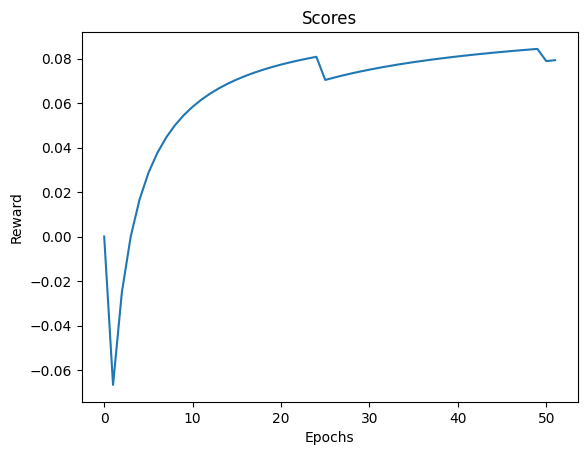

In [6]:
if __name__ == "__main__":
    Simulation() 